In [2]:
from datetime import datetime
import pandas as pd
import os
import dateutil.parser as date_parser
import matplotlib.pyplot as plt
from typing import Any
import seaborn as sns
import numpy as np
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, ARIMA
from statsforecast.arima import arima_string
import itertools
from pyod.models.knn import KNN
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore

plt.style.use('ggplot')

/Users/admin/Personal/Code/datascience-for-ek/.venv/lib/python3.12/site-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Load timeseries ticker data
### There are 3 tickers analysis is based on:
- S&P 500
- VIX - Volatility index
- US Treasury bonds
- DJIA - Dow Jones Industrial Average

The analysis period is from 2000 to 2024

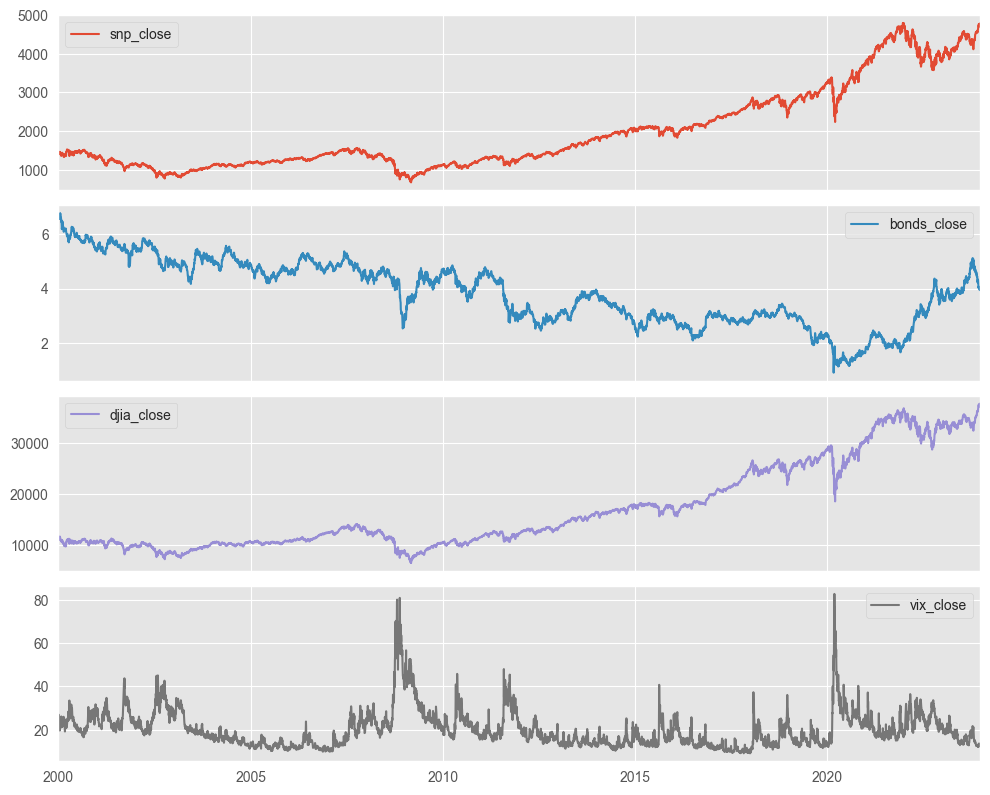

In [3]:
start_date = None
end_date = None

snp_data = pd.read_csv('assets/snp_data_clean.csv', index_col=0, parse_dates=True).add_prefix('snp_')[
           start_date:end_date]
bonds_data = pd.read_csv('assets/bonds_data_clean.csv', index_col=0, parse_dates=True).add_prefix('bonds_')[
             start_date:end_date]
djia_data = pd.read_csv('assets/djia_data_clean.csv', index_col=0, parse_dates=True).add_prefix('djia_')[
            start_date:end_date]
vix_data = pd.read_csv('assets/vix_data_clean.csv', index_col=0, parse_dates=True).add_prefix('vix_')[
           start_date:end_date]

merged_data = pd.concat(
    [snp_data['snp_close'], bonds_data['bonds_close'], djia_data['djia_close'], vix_data['vix_close']], axis=1)

merged_data.plot(subplots=True, figsize=(10, 8))
plt.tight_layout()
plt.show()

### Scale data

In [4]:
anom_start_date = start_date
anom_end_date = '2022-01-01'

anomaly_data = merged_data[anom_start_date:anom_end_date]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(anomaly_data)
scaled_data = pd.DataFrame(scaled_data, columns=anomaly_data.columns, index=anomaly_data.index)

scaled_data.head()

,snp_close,bonds_close,djia_close,vix_close
2000-01-03,-0.369875,2.271738,-0.600222,0.489236
2000-01-04,-0.434952,2.217102,-0.651878,0.809479
2000-01-05,-0.431815,2.299056,-0.633961,0.740856
2000-01-06,-0.430252,2.250215,-0.615198,0.663082
2000-01-07,-0.385911,2.221241,-0.576512,0.204450


### Anomaly detection and removal with KNN

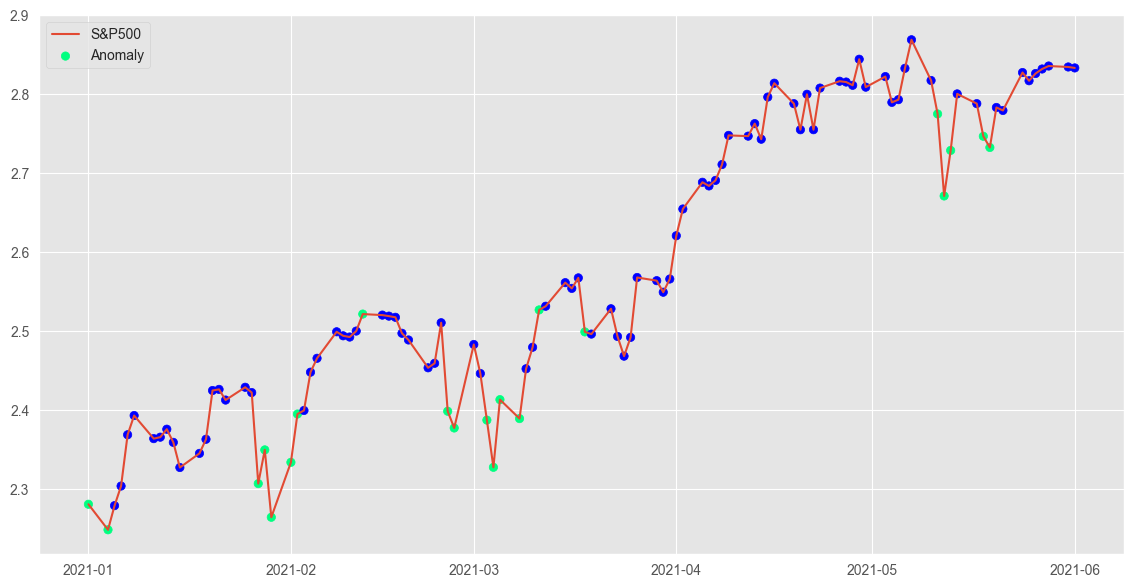

In [5]:
clf = KNN(contamination=0.1)

clf.fit(scaled_data)

y_pred = clf.labels_  # 0 for inliers, 1 for outliers
outlier_scores = clf.decision_scores_

scaled_data['anomaly'] = y_pred

scaled_data.head()

anomaly_showcase_start = '2021-01-01'
anomaly_showcase_end = '2021-06-01'

anomaly_showcase = scaled_data[anomaly_showcase_start:anomaly_showcase_end]

plt.figure(figsize=(14, 7))
plt.plot(anomaly_showcase.index, anomaly_showcase['snp_close'], label='S&P500')
plt.scatter(anomaly_showcase.index, anomaly_showcase['snp_close'], c=anomaly_showcase['anomaly'], cmap='winter', label='Anomaly')
plt.legend()
plt.show()

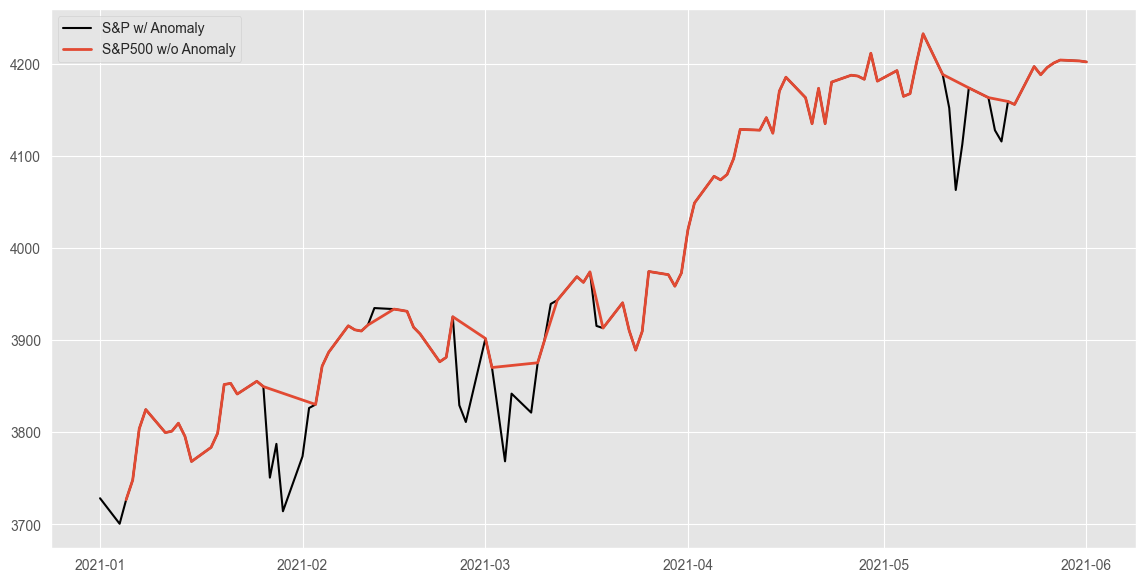

In [6]:
merged_data_comparison = merged_data[anom_start_date:anom_end_date][anomaly_showcase_start:anomaly_showcase_end]

cleaned_data = scaled_data[scaled_data['anomaly'] == 0].drop(columns=['anomaly'])

# important, scale the cleaned data back, so it can be compared to original data
clean_scaled_data = scaler.inverse_transform(cleaned_data)

clean_scaled_data = pd.DataFrame(clean_scaled_data, columns=cleaned_data.columns, index=cleaned_data.index)[anomaly_showcase_start:anomaly_showcase_end]

plt.figure(figsize=(14, 7))
plt.plot(merged_data_comparison.index,
         merged_data_comparison['snp_close'], label='S&P w/ Anomaly', color='black')
plt.plot(clean_scaled_data.index, clean_scaled_data['snp_close'], label='S&P500 w/o Anomaly', linewidth=2)
plt.legend()
plt.show()

### Statistical analysis of KNN anomaly detection
#### 1. Table comparison

In [7]:
def calculate_statistics(data, column):
    mean = data[column].mean()
    std_dev = data[column].std()
    skewness = skew(data[column])
    kurt = kurtosis(data[column])
    return mean, std_dev, skewness, kurt


original_stats = calculate_statistics(merged_data_comparison, 'snp_close')
cleaned_stats = calculate_statistics(clean_scaled_data, 'snp_close')

stats_comparison = pd.DataFrame({
    'Metric': ['Mean', 'Standard Deviation', 'Skewness', 'Kurtosis'],
    'Original': original_stats,
    'Cleaned': cleaned_stats
})

stats_comparison

,Metric,Original,Cleaned
0,Mean,3981.754322,4005.691337
1,Standard Deviation,157.008728,150.380452
2,Skewness,0.095344,0.017353
3,Kurtosis,-1.404443,-1.477155


### Statistical analysis of KNN anomaly detection
#### 2. Graphical comparison
##### Distribution + KDE (Kernel Density Estimation)

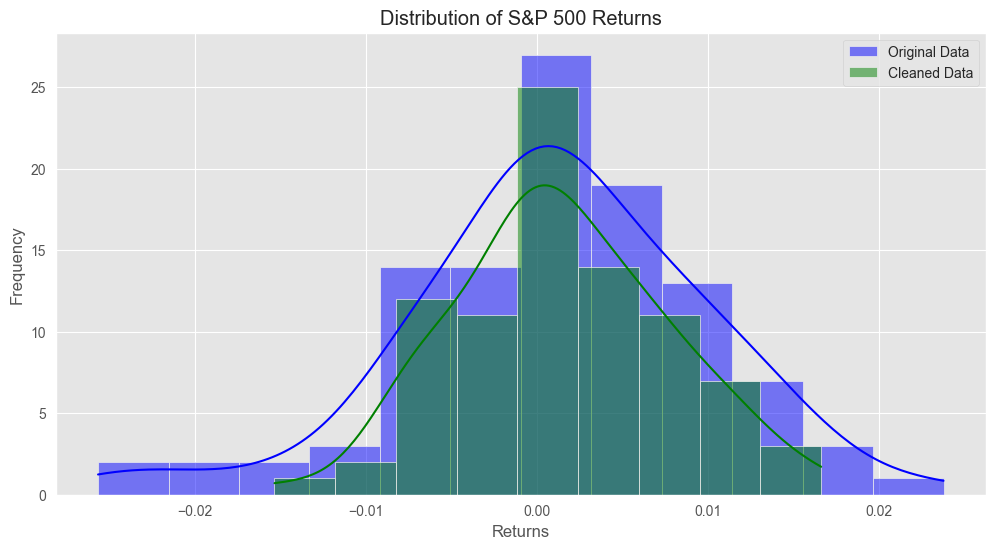

In [15]:
plt.figure(figsize=(12, 6))

original_returns = merged_data_comparison['snp_close'].pct_change().dropna()
cleaned_returns = clean_scaled_data['snp_close'].pct_change().dropna()

sns.histplot(original_returns, color='blue', label='Original Data', kde=True)
sns.histplot(cleaned_returns, color='green', label='Cleaned Data', kde=True)
plt.title('Distribution of S&P 500 Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Polynomial Regression and Forecasting

##### Kalman Recurrent Smoothing of the training set

In [16]:
def alpha_beta_filter(df, alpha=0.85, beta=0.005):
    x_est = df.iloc[0]['snp_close']  # initial position estimate
    v_est = 0  # initial velocity estimate
    estimates = []

    for price in df['snp_close']:
        x_pred = x_est + v_est
        residual = price - x_pred
        x_est = x_pred + alpha * residual
        v_est = v_est + beta * residual
        estimates.append(x_est)

    df['AlphaBeta'] = estimates
    return df

def alpha_beta_gamma_filter(df, alpha=0.2, beta=0.001, gamma=0.0001):
    x_est = df.iloc[0]['snp_close']  # initial position estimate
    v_est = 0  # initial velocity estimate
    a_est = 0  # initial acceleration estimate
    estimates = []

    for price in df['snp_close']:
        x_pred = x_est + v_est + 0.5 * a_est
        residual = price - x_pred
        x_est = x_pred + alpha * residual
        v_est = v_est + beta * residual
        a_est = a_est + gamma * residual
        estimates.append(x_est)

    df['AlphaBetaGamma'] = estimates
    return df

# df = alpha_beta_filter(cleaned_data)
df = alpha_beta_gamma_filter(cleaned_data)
y = cleaned_data['snp_close']
# y = pd.DataFrame(df['AlphaBetaGamma'], index=cleaned_data.index)
X = cleaned_data[['bonds_close', 'djia_close', 'vix_close']]

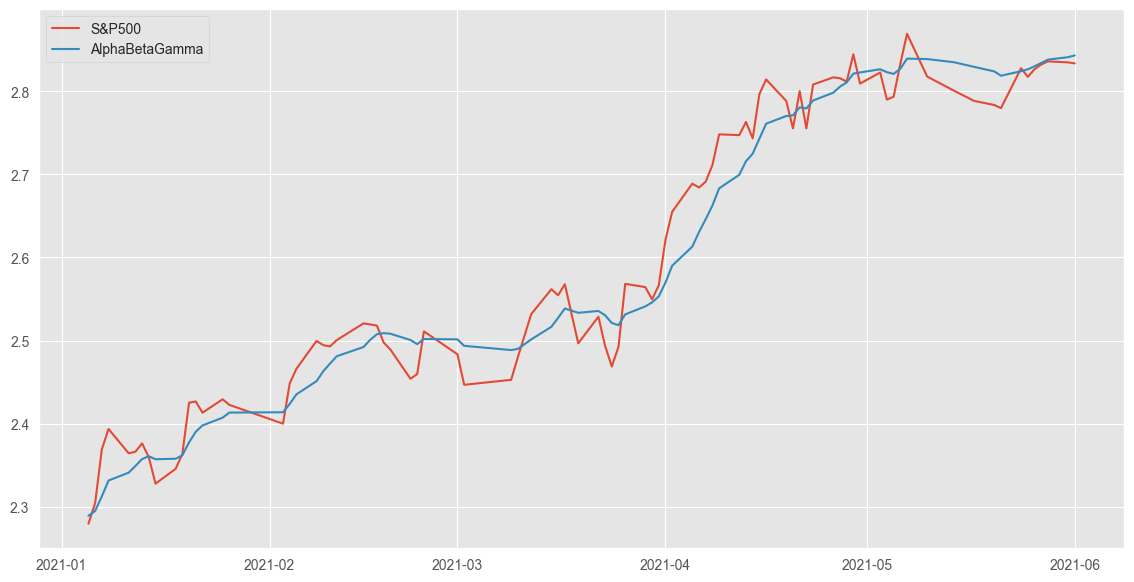

In [17]:
smoothing_showcase = df[anomaly_showcase_start:anomaly_showcase_end]

plt.figure(figsize=(14, 7))
plt.plot(smoothing_showcase.index, smoothing_showcase['snp_close'], label='S&P500')
plt.plot(smoothing_showcase.index, smoothing_showcase['AlphaBetaGamma'], label='AlphaBetaGamma')
plt.legend()

In [18]:
# Create polynomial features (combinations)
degree = 3
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)

model = LinearRegression()
model = model.fit(X_poly, y)

### Forecasting

In [19]:
forecast_start_date = anom_end_date
forecast_end_date = '2022-06-01'

scaled_forecast_og_data = scaler.transform(merged_data)
scaled_forecast_og_data = pd.DataFrame(scaled_forecast_og_data, columns=merged_data.columns, index=merged_data.index)

future_X = scaled_forecast_og_data[forecast_start_date:forecast_end_date][['bonds_close', 'djia_close', 'vix_close']]

future_X_poly = poly.transform(future_X)

y_pred = model.predict(future_X_poly)

mse = mean_squared_error(scaled_forecast_og_data[forecast_start_date:forecast_end_date]['snp_close'], y_pred)
rmse = np.sqrt(mean_squared_error(scaled_forecast_og_data[forecast_start_date:forecast_end_date]['snp_close'], y_pred))
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)

Mean Squared Error: 0.019848456227198264
Root Mean Squared Error: 0.1408845492848604


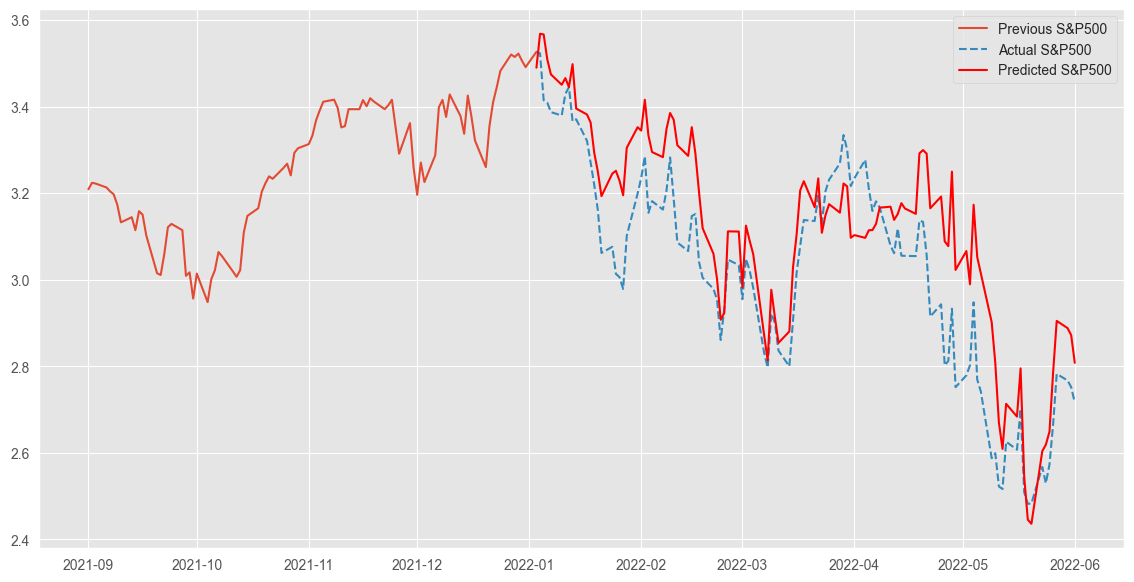

In [21]:
og_backfill_start = '2021-09-01'
og_backfill_data = scaled_forecast_og_data[og_backfill_start:forecast_start_date]['snp_close']
og_comparison_data = scaled_forecast_og_data[forecast_start_date:forecast_end_date]['snp_close']

og_backfill_data = pd.concat([og_backfill_data, og_comparison_data[:1]])

plt.figure(figsize=(14, 7))
plt.plot(og_backfill_data.index, og_backfill_data, label='Previous S&P500')
plt.plot(og_comparison_data.index, og_comparison_data, label='Actual S&P500', linestyle='--')
plt.plot(future_X.index, y_pred, label='Predicted S&P500', color='red')
plt.legend()
plt.show()

### Custom anomaly detection algorithm

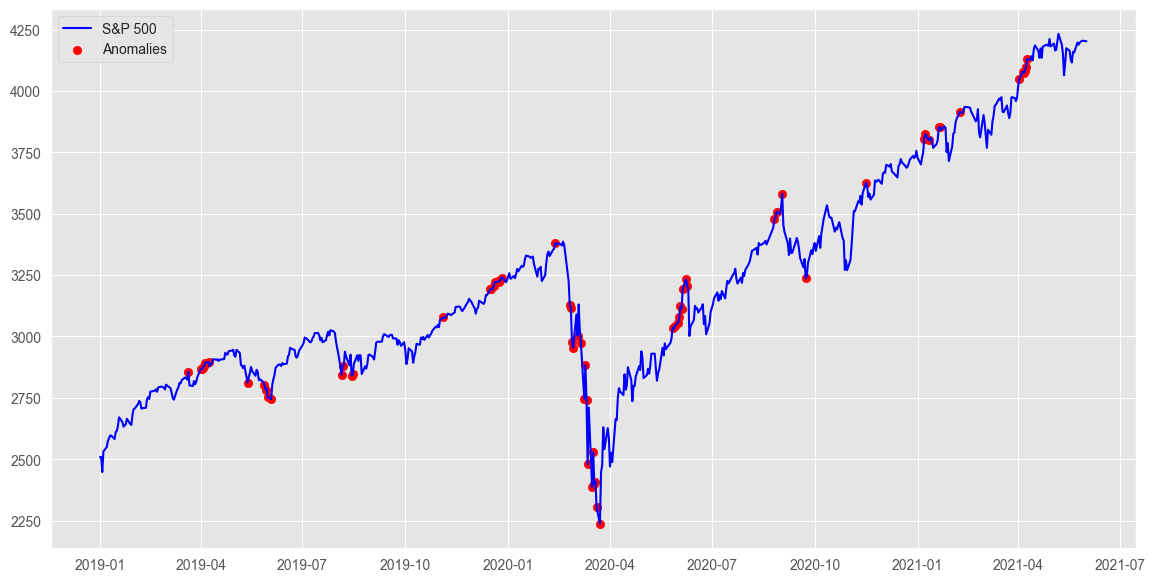

Number of anomalies detected: 68


In [22]:
clean_smooth_data = merged_data['snp_close']['2019-01-01':'2021-06-01']

rolling_window = 35
rolling_mean = clean_smooth_data.rolling(window=rolling_window).mean()
rolling_std = clean_smooth_data.rolling(window=rolling_window).std()

z_scores = (clean_smooth_data - rolling_mean) / rolling_std
z_scores = z_scores.abs()

threshold = 2
anomalies = np.where(z_scores > threshold)[0]

plt.figure(figsize=(14, 7))
plt.plot(clean_smooth_data.index, clean_smooth_data, label='S&P 500', color='blue')
plt.scatter(clean_smooth_data.index[anomalies], clean_smooth_data.iloc[anomalies], color='red', label='Anomalies')
plt.legend()
plt.show()

cleaned_data_no_anomalies = clean_smooth_data.drop(clean_smooth_data.index[anomalies])

print(f"Number of anomalies detected: {len(anomalies)}")

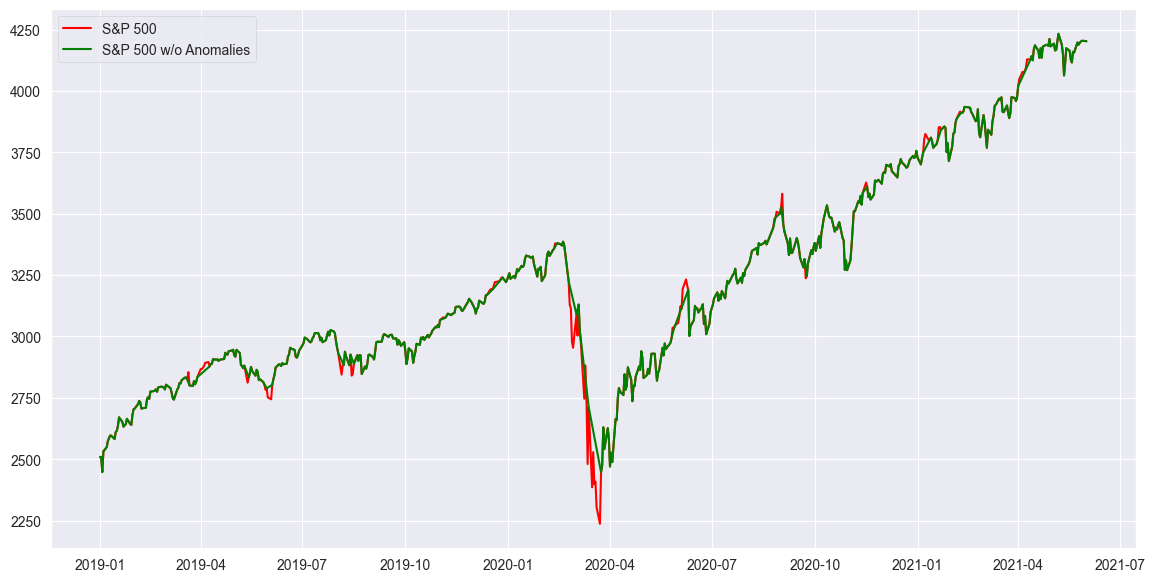

In [23]:
# Plot data without anomalies against original data
plt.figure(figsize=(14, 7))
plt.plot(clean_smooth_data.index, clean_smooth_data, label='S&P 500', color='red')
plt.plot(cleaned_data_no_anomalies.index, cleaned_data_no_anomalies, label='S&P 500 w/o Anomalies', color='green')
plt.legend()
plt.show()